# Python Programming for Finance

This notebook includes notes, and examples from the YouTube series by [sentdex](https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ), [Python Programming for Finance](https://www.youtube.com/playlist?list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ).

## Required Packages

* pandas
* pandas-datareader
* matplotlib
* beautifulsoup4
* scikit-learn
* mpl_finance


## Table of Contents

#### Section 1 - Webscraping

1. [Analyse data from just one company](#intro)

2. [Collect and combine data from the entire S&P 500 companies](#SP)

3. [Analyse relationships between companies](#corr)

4. [Formulate trading strategies](#form_strat)

5. [Analyze trading strategies](#an_strat)

_________________________

#### Section 2 - Quantopian

1. [Algorithmic trading](#quant)
2. [Orders and leverage](#orders)
3. [Schedule function](#sched)
4. [Research](#res)
5. [Pipeline](#pipe)
6. [Analyzing Alpha Factors with Alphalens](#alpha)
7. Backtesting Alpha Factor
8. Analyzing Backtest with Pyfolio
9. Strategizing
10. Finding more Alpha Factors
11. Combing Alphas
12. Portfolio Optimization API

_________________________

#### Section 3 - Zipline

1. Local Backtesting and Finance with Python
2. Visualizing Strategy Metrics
3. Custom Data Panel
4. Trading Custom Markets (Bitcoin example)

## <a class="anchor" id="intro"></a> Intro and Getting Share Price Data 

To begin, we'll collect and analyse the share price data of the electric car company [TESLA](https://www.tesla.com/en_GB/). This was done using the pandas DataReader, and by collecting the data from the financial website https://www.morningstar.com/. 

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np

start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()
df = web.DataReader("TSLA", 'morningstar', start, end)  # Collects data
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
df = df.drop("Symbol", axis=1)

df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18783276
2010-06-30,23.83,30.4192,23.30,25.96,17194394
2010-07-01,21.96,25.9200,20.27,25.00,8216789
2010-07-02,19.20,23.1000,18.71,23.00,5135795
2010-07-05,19.20,19.2000,19.20,19.20,0


In [2]:
df.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-23,303.20,305.5000,292.8601,301.8400,10992947
2018-07-24,297.43,307.7171,292.5452,304.4209,9590784
2018-07-25,308.74,309.6200,294.5025,296.7400,7094180
2018-07-26,306.65,310.7000,303.6411,304.8500,4630522
2018-07-27,297.18,307.6933,295.3404,307.2500,5703326


### Visualize TESLA Close Prices

In [3]:
# Visualize the close prices
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df.Close.plot()
plt.ylabel('Close Price'); plt.xlabel('Date')
plt.show()

<Figure size 640x480 with 1 Axes>

## Basic Stock Data Manipulation

### Moving Averages

Here we will create [moving averages](https://www.investopedia.com/terms/m/movingaverage.asp) of the TESLA share price data. 

Moving averages are created by averaging over historical price data, and result in a curve that smooths out price over time. They can be useful indicators for traders, particuarly when different moving averages cross as this can indicate an uptrend/ downtrend in price. An uptrend commonly occurs when a shorter day (low latency) moving average crosses and remains above a longer day (high latency) moving average, and vice versa for a downtrend. 

Here we will create and visualize the 100 day moving average, and visualize it along with the close price and volume data. 

In [4]:
# Create, and add 100 day moving average to dataframe
df['100ma'] = df['Close'].rolling(window=100, min_periods=0).mean()
df.head()

,Close,High,Low,Open,Volume,100ma
Date,,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18783276,23.890000
2010-06-30,23.83,30.4192,23.30,25.96,17194394,23.860000
2010-07-01,21.96,25.9200,20.27,25.00,8216789,23.226667
2010-07-02,19.20,23.1000,18.71,23.00,5135795,22.220000
2010-07-05,19.20,19.2000,19.20,19.20,0,21.616000


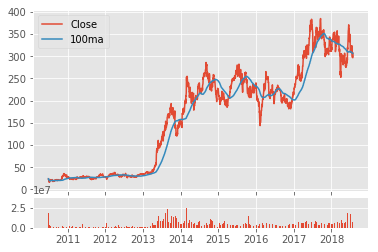

In [5]:
# Visualize the close prices, 100ma, and volume
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(df.index, df.Close)
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df.Volume, label='volume')

ax1.legend()
plt.show()

### Candlestick Charting

Resampling is a very useful operation in Pandas for manipulating time series data. It involves changing the frequency of your time series observations. 

There are two types of resampling:
1. ___Upsampling___: Where you increase the frequency of the samples (e.g. minutes $\rightarrow$ seconds)
2. ___Downsampling___: Where you decrease the frequency of the samples (e.g. days $\rightarrow$ months)

Here we will use resampling to create [candlesticks](https://www.investopedia.com/trading/candlestick-charting-what-is-it/). 

First, we resample our close prices to get the [open-high-low-close](https://www.investopedia.com/terms/o/ohlcchart.asp) (OHLC) data.

In [6]:
# Resample to get open-high-low-close (OHLC) on every 10 days of data
df_ohlc = df.Close.resample('10D').ohlc() 
df_volume = df.Volume.resample('10D').sum()

df_ohlc.head()

,open,high,low,close
Date,,,,
2010-06-29,23.89,23.89,15.80,17.46
2010-07-09,17.40,20.64,17.05,20.64
2010-07-19,21.91,21.91,20.22,20.72
2010-07-29,20.35,21.95,19.59,19.59
2010-08-08,19.60,19.60,17.60,19.15


```matplotlib.finance``` offers some useful functions for plotting candlesticks. 

In [7]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

The function ```candlestick_ohlc``` requires a special type of data type known as an mdate. Here, we convert our dates into mdates:

In [8]:
df_ohlc.reset_index(inplace=True)
df_ohlc.Date = df_ohlc.Date.map(mdates.date2num)
df_ohlc.head()

,Date,open,high,low,close
0,733952.0,23.89,23.89,15.80,17.46
1,733962.0,17.40,20.64,17.05,20.64
2,733972.0,21.91,21.91,20.22,20.72
3,733982.0,20.35,21.95,19.59,19.59
4,733992.0,19.60,19.60,17.60,19.15


Having created our open high low close data, we can now use it to create candlesticks:

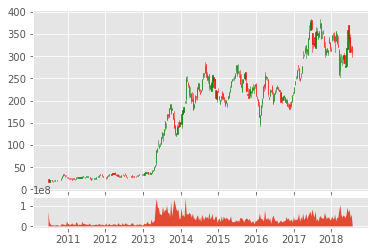

In [9]:
# Create and visualize candlestick charts
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

plt.show()

Candlestick graphs help condense __price direction__ and __open-high-low-close__ data all in just one graph. In addition, we have plotted the __volume__ in the lower subplot to condense even more information in just one plot.

## <a class="anchor" id="SP"></a> Automating Getting the S&P 500 List

The [S&P 500](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) is a list of (generally) the top 500 companies by _market capitalization_. The market capitilization describes the value of a company, and is calculated as the product of the number of its outstanding shares and the price of each share. The S&P can therefore be thought of as the __top 500 most valuable companies__. The performance of the S&P can be used as an indicator for roughly how well the economy is doing. Investors commonly refer to the S&P as a benchmark of the overall market, to which all other investments are compared. 

Here we will build create a ___web scraper___ that will collect the S&P data from the internet. To do this, we use a web scraping library called [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/).

By first opening our [website](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) that contains the data we want, we take note of how the data is presented. We observe that it is displayed in a _table_, and the first row second column has a security, '_3M Company_'. What we want is to collect the data that is displayed in this table. To do this, we can extract it from the websites source code. To view the source code we first go to the website, and then press ```CTRL+U``` on the keyboard. By then pressing ```CTRL+F```, we search for the occurence of the first elements in the table (e.g. we search for the term '3M Company'), to get an idea of where the table data begins. By then searching for the term '_table_', we observe an occurence of it only a couple of lines above it. A couple of lines below that, we observe the first table data tags, ```<td>```, this denotes the beginning of the table data that we want to extract.

Let's collect that data!

In [10]:
import bs4 as bs  # Beautiful Soup (web scraping library)
import pickle  # Allows us to save S&P list
import requests

The [pickle](https://docs.python.org/2/library/pickle.html) module serializes any Python objects, and allows us to __save any object__ as a variable. Here we will use it to save the S&P 500 list, so that we won't have to always go back to wikipedia to collect that data. 

In [11]:
# Saves the S&P 500 ticker data
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    
    # Iterate through the table
    for row in table.findAll('tr')[1:]:  # [1:] Skips the table header
        ticker = row.findAll('td')[0].text  # Collects the ticker data
        tickers.append(ticker)
    
    # Save the collected data
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    return tickers

In [12]:
save_sp500_tickers()[:5]  # Print just the first 5 tickers in the table

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

Comparing these with the first 5 tickers in the table of our [wikipedia page](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), we observe they are identical. Having sucesfully scraped the ticker data for our S&P 500 list, we will now collect the rest of the relevant data.

It appears that the morningstar API gets stuck loading a few of the tickers. I have added a try and except code block, so that if it takes too long, interrupt the kernel so that it will continue loading the others.

In [13]:
import os
import time

In [14]:
def get_data_from_web(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
            
    # Check if file already exists as a locally saved file    
    for ticker in tickers:
        try:
            # Collect and save data locally if it doesn't exist yet
            if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
                df = web.DataReader(ticker, 'morningstar', start, end)
                df.reset_index(inplace= True)
                df.set_index('Date', inplace= True)
                df = df.drop('Symbol', axis=1)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            else:
                print('Already have {}'.format(ticker))  # Already exists
        except:
            print('Cannot obtain data for ' + ticker)  # If it takes too long

In [15]:
# get_data_from_web()  # Collect and store all ticker data locally

### Combining S&P 500 into one DataFrame

Having collected all our necessary csv files from the web, we will combine them neatly into one DataFrame object. We will combine them such that we record only the _Close_ data for each ticker.

Some tickers failed to download, so we will ensure to skip those when combining the dataframe.

In [16]:
missing_tickers = ['ANDV', 'BKNG', 'BHF', 'CBRE', 'DWDP', 'DXC', 'EVRG', 'JEF', 'TPR', 'UAA', 'WELL']

In [17]:
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        if ticker in missing_tickers:
            pass
        else:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)

            df.rename(columns = {'Close': ticker}, inplace=True)
            df.drop(['Open','High','Low','Volume'], 1, inplace=True)

            # Join the DataFrames together
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')

            if count % 50 == 0:  # Track progress
                print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [18]:
compile_data()

0
50
100
150
200
250
300
350
400
450
500
              MMM      ABT  ABBV  ABMD    ACN   ATVI   ADBE   AMD    AAP  \
Date                                                                       
2010-01-01  82.67  25.8328   NaN  8.73  41.50  11.11  36.78  9.68  40.48   
2010-01-04  83.02  26.0577   NaN  8.74  42.07  11.30  37.09  9.70  40.38   
2010-01-05  82.50  25.8471   NaN  8.53  42.33  11.32  37.70  9.71  40.14   
2010-01-06  83.67  25.9907   NaN  8.40  42.78  11.26  37.62  9.57  40.49   
2010-01-07  83.73  26.2060   NaN  8.40  42.74  10.99  36.89  9.47  40.48   

              AES ...    WYNN    XEL      XRX   XLNX     XL  XYL      YUM  \
Date              ...                                                       
2010-01-01  13.31 ...   58.23  21.22  22.2887  25.06  18.33  NaN  25.0967   
2010-01-04  13.67 ...   63.96  21.08  22.7365  25.38  18.72  NaN  25.1828   
2010-01-05  13.53 ...   67.85  20.83  22.7629  25.06  18.59  NaN  25.0967   
2010-01-06  13.39 ...   66.96  20.87  22.

Note that not all of the tickers were trading during early 2010, therefore several of the tickers have missing data (NaN) when observing the head of the dataframe.


### <a class="anchor" id="corr"></a> S&P 500 Company Correlation Table

In this section we will briefly investigate any relationships/ patterns between companies that may be present within this data.

The correlation between companies can be of interest to investors. If you have two companies that are highly correlated, and once one of them starts to deviate, you can invest in one and short the other one and then eventually they come back together. To give another example, if a pair of companies are negatively correlated and they both go in one direction, then you can again invest in one and short the other. 

Investors ideally want to be properly diversified. This can be achieved by investing in non-correlated stocks, and helps to minimize the risk of having all of your investments performing poorly at the same time.

Here we will visualize correlations between the S&P 500 companies.

In [19]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()  # Obtain correlation data
    data = df_corr.values
    
    # Visualization
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show() 

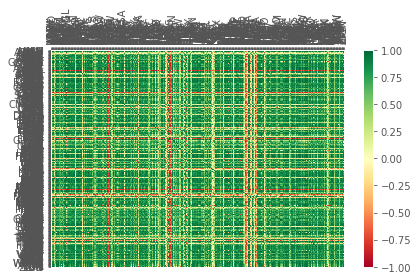

In [20]:
visualize_data()

### <a class="anchor" id="form_strat"></a> Preprocessing Data for Machine Learning

In the previous section we realised some clear relationships between companies. The question we ask in this section is whether we can get a machine to recognise those patterns. 

A hypothesis we can test is that the share price of groups of companies are likely to move together, and that we can therefore use the price movement of other companies as an indicator for a prediction in which direction a single company's share price will move in the future.

We will preprocess our data such that we use a normalized _percentage change_ in the stock price as a feature to make a prediction. <a class="anchor" id="strat"></a>  

Our target variables (labels) are three classes of options: buy, sell, or hold. Our aim is to use our training data (the percentage change in the stock price) to train a machine to make optimal decisions in response to the question: 'did the price based on these features within the next 7 days of trading go up more than 2%?' If the answer is yes, then buy. If instead it fell by 2%, then sell. If it did neither of those things, then we hold. 

In [21]:
def process_data_for_labels(ticker):
    hm_days = 7  # How many days for price to go up/down X%
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    # Obtain percentage change within given number of days 
    for i in range(1, hm_days+1): 
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df

### Creating Machine Learning Target Function

Here we create a new column for our price % change dataframe, which encodes the target variable whether the company is a: buy/ sell/ hold.

In [22]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02  # 2% change in share price
    
    # If price goes up 2% ...
    for col in cols:
        if col > requirement:
            return 1  # Buy
        if col < -requirement:
            return -1  # Sell
    return 0  # Hold

### Creating Labels for Machine Learning

Here we map the target function created previously to our dataframe of share price % changes to create a new column of decisions of whether to buy/ sell/ hold a companies shares.

In [23]:
from collections import Counter

def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)
    
    # Create new column of classes: buy/ sell/ hold 
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                              df['{}_1d'.format(ticker)],
                                              df['{}_2d'.format(ticker)],
                                              df['{}_3d'.format(ticker)],
                                              df['{}_4d'.format(ticker)],
                                              df['{}_5d'.format(ticker)],
                                              df['{}_6d'.format(ticker)],
                                              df['{}_7d'.format(ticker)],
                                             ))
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values  # Features
    y = df['{}_target'.format(ticker)].values  # Target labels
    
    return X, y, df

In [24]:
# extract_featuresets('MMM')

### <a class="anchor" id="an_strat"></a> Machine Learning

Having preprocessed our dataset, we are now ready for machine learning.

Recall that our target variable, y, takes values: 

$$y=\{-1,0,1\}=\{\text{sell}, \text{hold}, \text{buy}\}$$

We want to use our feature data, $X$ (the percentage change in each of the S&P 500 company share prices), to predict whether we should make the decsion to buy, sell, or hold a given share for a given period of time - based on the trading strategy of whether the price has moved up/ down 2% as discussed [previously](#strat).

In [25]:
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

/home/anthony/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/anthony/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [26]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)  # Extract features
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)  
    confidence = clf.score(X_test, y_test)
    print('Accuracy', confidence)
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return confidence

In [27]:
do_ml('BAC')

Data spread: Counter({'1': 999, '-1': 925, '0': 307})
Accuracy 0.471326164874552
Predicted spread: Counter({1: 347, -1: 198, 0: 13})


0.471326164874552

Here we see that the k-Nearest neighbours algorithm can accurately predict a buy/sell/hold opportunity with a ~40% accuracy. 

We will improve upon this model by using a method known as ___ensembling___. This involves combining several models together and mixing their predictions together to give a (typically better) overall weighted prediction. 

In [28]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)  # Extract features
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    # Instantiate ensemble model
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                           ('knn', neighbors.KNeighborsClassifier()),
                           ('rfor', RandomForestClassifier())])
    
    clf.fit(X_train, y_train)  
    confidence = clf.score(X_test, y_test)
    print('Accuracy', confidence)
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return confidence

In [29]:
do_ml('BAC')  # Bank of America = BAC

Data spread: Counter({'1': 999, '-1': 925, '0': 307})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy 0.4265232974910394
Predicted spread: Counter({-1: 326, 1: 232})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.4265232974910394

Here we observe that the accuracy of the overall model has increased, but not significantly. The model could be further improved upon by tuning the hyperparameters in each of the models appropriately.

Interestingly, in both models we observe far fewer predictions for a _hold_. This is most signifcant in the enesmebled model, where not a single prediction was made for a hold.

It should be noted that the dataset we have used was quite highly unbalanced, with far fewer holds than buy/sells. This could have lead to a skew in our predictions, which could have indeed been a cause for the significantly fewer _hold_ predictions.

To help balance our dataset, we make changes to the following:

In [30]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.03  # 3.0% change in share price
    
    # If price goes up 3% ...
    for col in cols:
        if col > requirement:
            return 1  # Buy
        if col < -requirement:
            return -1  # Sell
    return 0  # Hold

In [31]:
do_ml('BAC')

Data spread: Counter({'1': 795, '0': 735, '-1': 701})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy 0.3727598566308244
Predicted spread: Counter({-1: 268, 1: 173, 0: 117})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.3727598566308244

Unfortunately, after using a balanced dataset we observe an accuracy that is not much better than just random predictions. Since there are only three choices of class to predict, if we were to predict (for example) _buy_ for every single situation we would have arrived at roughly the same accuracy as our model. 

# <a class="anchor" id="quant"></a> Quantopian 
## Algorithmic Trading with Python

[Quantopian](https://www.quantopian.com/) is a website and environment that __simulates trading__, providing stock pricing accurate to the minute. It is a useful resource for [backtesting](https://www.investopedia.com/terms/b/backtesting.asp), a method used to assess the viability of a trading strategy by testing how it well it would perform with historical data. Quantopian has changed a lot over time, and has now become more of a __research platform__ that you just so happen to backtest on. 

When writing algorithms in Quantopian, the variable ```context``` is a python dictionary that contains information about your portfolio. It can tell you about the portfolio performance, your leverage, your account, etc. The Quantopian variable ```data``` is your universe of information, containing numerous data such as stock prices. 

Quantopian has excellent [documentation](https://www.quantopian.com/help) which can be viewed at [Quantopain Help](https://www.quantopian.com/help).

The following [notebook](https://www.quantopian.com/posts/how-to-get-an-allocation-writing-an-algorithm-for-the-quantopian-investment-management-team) and its associated [YouTube webinar](https://www.youtube.com/watch?v=bvUdDFpsZ3o&feature=youtu.be) are excellent introductions to Quantopian and several of its main tools, including:
1. [Blaze](http://blaze.pydata.org/) - study and interact with partner data.
2. [Pipeline](https://www.quantopian.com/tutorials/pipeline) - dynamically select stocks to trade each day.
3. [Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) - analyze the predictive ability of an alpha factor.
4. [The Interactive Development Environment](https://www.quantopian.com/algorithms) (IDE) - backtest the strategy.
5. [Pyfolio](https://www.quantopian.com/posts/how-to-get-an-allocation-writing-an-algorithm-for-the-quantopian-investment-management-team) - understand the performance and risk analysis of the backtest.

## <a class="anchor" id="orders"></a> Orders and Leverage

Quantopian offers several [order methods](https://www.quantopian.com/help#api-order-methods), which can be used to place buy/sell orders in a simulated environment on financial markets using the algorithm you are building. The method [```order_target_percent()```](https://www.quantopian.com/help#api-order-target-percent) is considered to be the most useful, and easiest to use to keep your portfolio balanced with the shares you want to own. By specifying a positve value for its ```style``` parameter, you can place long orders on the market to fill your portfolio to reach the specified balance as determined by  ```style```. By having a _negative_ ```style``` value, you can short the companies shares to remove those shares from your portfolio.

[Shorting](https://www.investopedia.com/university/shortselling/shortselling1.asp) is essentially a way of __betting against a company__. This is achieved by _borrowing_ some shares from someone, selling them at the current price, and then finally repaying those shares back to them in the future in hopes that those shares have decreased in value. If done succesfully, this allows you to make a profit by selling borrowed shares at a high price and repaying them back at a much lower price in the future. 

The __danger with shorting__ is that there is __infinite downside__, with only a __finite upside__. As opposed to investing and going long, where the share price can go up infinitely (and the downside is finite), the most you can earn by shorting is the price at which you borrowed those shares (in the absolute best case scenario that the shares go to zero, and you repay them back at that price). In addition to this, shorting is dangerous because you are __borrowing money__.

In Quantopian, the functions ```initialize()``` and ```handle_data()``` run automatically without ever needing to be called. ```initialize()``` runs just once, when the program is executed. However, the function ```handle_data()``` runs once __every minute__. This can lead to tricky  bugs, and needs to be accounted for. For example, if you set a buy order for a million dollars worth of shares, that can take some time to fill. If an event occurs that triggers a sell order for a million dollars worth of shares before those shares have been filled, the next minute when ```handle_data()``` has been called, then this would result in unwanted short selling, where you are borrowing and selling shares that you do not own. The effects of this can get amplified over time, where your order book continues to grow exponentially due to ```handle_data()``` being called every minute. To counteract this, we can add an additional ```if``` statement that adds to the order book only when the event has been triggered _and_ if the companies shares are not currently in the built-in Quantuopian function ```get_open_orders()```.  

In [32]:
def initialize(context):
    context.aapl = sid(24)  # Apple share prices
    
def handle_data(context, data):  # Runs every minute
    hist = data.history(context.aapl, 'price', 50, '1d')
    log.info(hist.head())
    sma_50 = hist.mean()  # 50 day moving average
    sma_20 = hist[-20:].mean()  # 20 day MA
    
    open_orders = get_open_orders()
        
    if sma_20 > sma_50:  # If the 20 day moving average has crossed over the 50 day moving average
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)  # Want 100% (1.0) of portfolio to be Apple (long order)
    elif sma_50 > sma_20:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)  # Short order on Apple
        
    record(leverage=context.account.leverage)  # Record leverage

## <a class="anchor" id="sched"></a> Schedule Function 

In practice we want to reduce the number of trades we make in a day, such that to avoid transaction fees. The ```schedule_function()```  allows you to schedule functions to occur daily/ weekly/ monthly etc.

In [ ]:
def initialize(context):
    context.aapl = sid(24)  # Apple share prices
    schedule_function(ma_crossover_handling, date_rules.every_day(), time_rules.market_open(hours=1))  # Schedule function
    
def ma_crossover_handling(context, data):
    hist = data.history(context.aapl, 'price', 50, '1d')
    sma_50 = hist.mean()  # 50 day moving average
    sma_20 = hist[-20:].mean()  # 20 day MA
    
    open_orders = get_open_orders()
        
    if sma_20 > sma_50:  # If the 20 day moving average has crossed over the 50 day moving average
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)  # Want 100% (1.0) of portfolio to be Apple (long order)
    elif sma_50 > sma_20:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)  # Short order on Apple
        
    record(leverage=context.account.leverage)  # Record leverage

## <a class="res" id="sched"></a> Research

In this section we will dive into the [research](https://www.quantopian.com/research) environment of Quantopian. 

Later in this notebook, we will be uinsg [Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors), a tool that allows us to analyze [alpha factors](https://www.investopedia.com/terms/a/alpha.asp). Alpha factors are used in finance to gauge the performance of an investment against a benchmark (e.g. a market index) which is considered to represent the market's movement as a whole.

## <a class="anchor" id="pipe"></a> Pipeline

[Pipeline](https://www.quantopian.com/tutorials/pipeline) offers a quick and succinct way to whittle away datasets. The main attraction is that it is ___a lot quicker___ than running functions on datasets. This is because pipeline often does not return the dataframe itself during manipulation, but still allows for you to (much more efficiently) apply functions on them.  You ideally want to do everything you can inside pipeline, as doing otherwise can take 5-10 times longer.

Pipeline allows us to build the pipeline data that we will use in our trading strategy, which often forms the crux of our calculations in our trading strategies. 

Using pipeline, we can return the data (in this case sentiment data) and then use alphalens to analyze the alpha factor, which will be discussed in the next section.

In [34]:
from quantopian.pipeline.data.sentdex import sentiment

def make_pipeline():
    sentiment_factor = sentiment.sentiment_signal.latest
    universe = (Q1500US() & sentiment_factor.notnull())
    pipe = Pipeline(columns={'sentiment': sentiment_factor,
                            'longs': (sentiment_factor>=4),
                            'shorts': (sentiment_factor<=-2)},
                   screen=universe)
    
    return pipe

result = run_pipeline(make_pipeline(), start_date='2015-05-01', end_date='2016-01-01')

result.head()

ImportError: No module named 'quantopian'

## <a class="anchor" id="alpha"></a> Analyzing Alpha Factors with Alphalens

When building trading algorithms, the first question we should be concerned with is: 'is there a signal present in the data'? After we conclude that there is, we can then worry about making an optimal strategy that can exploit that signal. 

At the simplest level,' _alpha_' is a measure of your returns irrespective of the market gain.